In [88]:
import os
import numpy as np
import glob
import pandas as pd  
import random
import math as mp
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow.keras.backend as K


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from pyquaternion import Quaternion

from numpy import array
from numpy import hstack

from math import floor

In [89]:
def get_csv_files(dataset_path, keyword):
    """
    Generator function to recursively output the CSV files in a directory and its sub-directories.
    Arguments:
        dataset_path: Path to the directory containing the CSV files.
    Outputs:
        Paths of the found CSV files.
    """
    files = []
 
    for f in glob.glob(os.path.join(dataset_path,"*{}*".format(keyword))):
        #print(f)
        if not os.path.isdir(f):
            file_name, extension = f.split('.')            
            if extension == "csv":
                files.append(f)
            else:
                logging.warn("Invalid file: {}. Ignoring...".format(f))

    return files

In [90]:
def load_df(path): 
    df = pd.read_csv(path, index_col=None)

    return df

In [91]:
def split_sequences(sequences, n_steps, LAT, n_in_seq, n_out_seq):
    X, y = list(), list()
    
    for i in range(len(sequences)):
        # find the end of this pattern
        stop_ix = i + n_steps
        shift_ix = i + n_steps + LAT
        seq_length = len(sequences) - LAT
        if stop_ix > seq_length:
          break
        seq_x = sequences[i:stop_ix,:-n_in_seq]
        seq_y = sequences[shift_ix-1, -n_out_seq:]
        X.append(seq_x)
        y.append(seq_y)
    
    return array(X), array(y)
    #return X, y

In [92]:
def get_sequence_rotsonly(dataframe):
    # multivariate data preparation

    # define sequences
    
    
    in_seq4 = dataframe[['qw']].to_numpy()
    in_seq5 = dataframe[['qx']].to_numpy()
    in_seq6 = dataframe[['qy']].to_numpy()
    in_seq7 = dataframe[['qz']].to_numpy()
    
    out_seq4 = dataframe[['qw']].to_numpy()
    out_seq5 = dataframe[['qx']].to_numpy()
    out_seq6 = dataframe[['qy']].to_numpy()
    out_seq7 = dataframe[['qz']].to_numpy()

    # convert to [rows, columns] structure
    in_seq4 = in_seq4.reshape((len(in_seq4), 1))
    in_seq5 = in_seq5.reshape((len(in_seq5), 1))
    in_seq6 = in_seq6.reshape((len(in_seq6), 1))
    in_seq7 = in_seq7.reshape((len(in_seq7), 1))
 
    out_seq4 = out_seq4.reshape((len(out_seq4), 1))
    out_seq5 = out_seq5.reshape((len(out_seq5), 1))
    out_seq6 = out_seq6.reshape((len(out_seq6), 1))
    out_seq7 = out_seq7.reshape((len(out_seq7), 1))

    # horizontally stack columns
    dataset = hstack((in_seq4, in_seq5, in_seq6, in_seq7, out_seq4, out_seq5, out_seq6, out_seq7))
    
    # define number of input and output sequences
    n_in_seq = 4
    n_out_seq = 4
        
    # choose a number of time steps
    n_steps = 5 
    
    LAT_in_rows = 6 

    # convert into input/output
    X, y = split_sequences(dataset, n_steps, LAT_in_rows, n_in_seq, n_out_seq)

    print("X shape is: " + str(X.shape))
    print("y shape is: " + str(y.shape))
    print("------")
    
    return X,y

In [103]:
path_train = "C:/Users/weikert1/Documents/Thesis/Project_V06_26072021/Results/01_Dataset/GRU_quat/6_0208_v01/traces"

for csv in get_csv_files(path_train, "3_test"):
        csv_df = load_df(csv)
        in_seq1 = csv_df[['qw_pred']].to_numpy()
        in_seq2 = csv_df[['qx_pred']].to_numpy()
        in_seq3 = csv_df[['qy_pred']].to_numpy()
        in_seq4 = csv_df[['qz_pred']].to_numpy()

#for csv in get_csv_files(path_train, "y_true"):
        csv_df = load_df(csv)
        in_seq5 = csv_df[['qw_true']].to_numpy()
        in_seq6 = csv_df[['qx_true']].to_numpy()
        in_seq7 = csv_df[['qy_true']].to_numpy()
        in_seq8 = csv_df[['qz_true']].to_numpy()

        
        dataset_pred = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
        dataset_true = hstack((in_seq5, in_seq6, in_seq7, in_seq8))
        
        dataset_pred = array(dataset_pred)
        dataset_true = array(dataset_true)

In [111]:
def compute_quat_metrics(true_rot, preds_rot):
        
        # Compute Eucliden and angular distances
        ang_dists = np.array([Quaternion.distance(q1, q2) for q1, q2 in zip(true_rot,
                                                                             preds_rot)]) #(w, x, y, z)
        # Mean Absolute Error (MAE)
        mae_ang = (np.sum(ang_dists) / ang_dists.shape[0])
        
        # Root Mean Squared Error (RMSE)
        rmse_ang = (np.sqrt((ang_dists ** 2).mean()))

        return ang_dists, mae_ang, rmse_ang

In [112]:
def eval_quat(true_rot, preds_rot):
        

        true_rot = np.array([Quaternion(q) for q in true_rot]) #(w, x, y, z)
         
        preds_rot = np.array([Quaternion(q) for q in preds_rot]) #(w, x, y, z)
                
        return compute_quat_metrics(true_rot, preds_rot)

In [114]:
ang_dists , ang_mae , ang_rmse = eval_quat(dataset_true, dataset_pred)
print('Number of angular dists: ' + str(ang_dists.shape[0]))
print('MAE rotation is : ' + str(ang_mae))
#print('RMSE rotation is : ' + str(ang_rmse))
print("----")

Number of angular dists: 6739
MAE rotation is : 0.040584961573602606
----


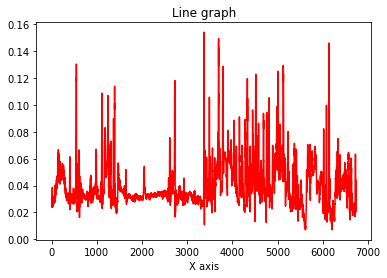

In [115]:
# plotting
plt.title("Line graph")
plt.xlabel("X axis")
plt.plot(ang_dists, color ="red")
plt.show()

In [116]:
path_train = "C:/Users/weikert1/Documents/Thesis/Project_V06_26072021/Results/01_Dataset/Baseline_quat/Traces"

for csv in get_csv_files(path_train, "3_test"):
        csv_df = load_df(csv)
        in_seq1 = csv_df[['qw_pred']].to_numpy()
        in_seq2 = csv_df[['qx_pred']].to_numpy()
        in_seq3 = csv_df[['qy_pred']].to_numpy()
        in_seq4 = csv_df[['qz_pred']].to_numpy()

#for csv in get_csv_files(path_train, "y_true"):
        csv_df = load_df(csv)
        in_seq5 = csv_df[['qw_true']].to_numpy()
        in_seq6 = csv_df[['qx_true']].to_numpy()
        in_seq7 = csv_df[['qy_true']].to_numpy()
        in_seq8 = csv_df[['qz_true']].to_numpy()

        
        dataset_pred = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
        dataset_true = hstack((in_seq5, in_seq6, in_seq7, in_seq8))
        
        dataset_pred = array(dataset_pred)
        dataset_true = array(dataset_true)

Number of angular dists: 6729
MAE rotation is : 0.021303834429640643
----


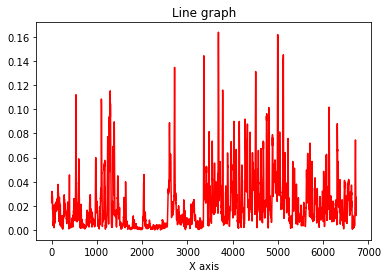

In [117]:
ang_dists , ang_mae , ang_rmse = eval_quat(dataset_true, dataset_pred)
print('Number of angular dists: ' + str(ang_dists.shape[0]))
print('MAE rotation is : ' + str(ang_mae))
#print('RMSE rotation is : ' + str(ang_rmse))
print("----")

# plotting
plt.title("Line graph")
plt.xlabel("X axis")
plt.plot(ang_dists, color ="red")
plt.show()

In [77]:
tensor_dataset_true = tf.convert_to_tensor(dataset_true, dtype= tf.float32, dtype_hint=None, name=None)
tensor_dataset_pred = tf.convert_to_tensor(dataset_pred, dtype= tf.float32 , dtype_hint=None, name=None)

In [78]:
def conjugate(q):
    mult = tf.constant(np.array([1,-1,-1,-1])[np.newaxis], dtype=np.float32)
    return q*mult

def inverse(q):
    return conjugate(q) / tf.reduce_sum(q*q, axis=-1, keepdims=True)

def log(q):
    v = q[:, 1:]
    a = q[:, :1]
    q_norm = tf.norm(q, axis=-1, keepdims=True)
    x = a / q_norm
    eps = np.finfo(np.float32).eps * 8.0
    x *= (1.0 - eps)
    vec_part = tf.nn.l2_normalize(v, axis=-1) * tf.math.acos(x)
    real_part = tf.math.log(q_norm)
    return tf.concat([real_part, vec_part], axis=-1)

def mult(quaternion1, quaternion2):
    w1, x1, y1, z1 = tf.unstack(quaternion1, axis=-1)
    w2, x2, y2, z2 = tf.unstack(quaternion2, axis=-1)
    x = x1 * w2 + y1 * z2 - z1 * y2 + w1 * x2
    y = -x1 * z2 + y1 * w2 + z1 * x2 + w1 * y2
    z = x1 * y2 - y1 * x2 + z1 * w2 + w1 * z2
    w = -x1 * x2 - y1 * y2 - z1 * z2 + w1 * w2
    return tf.stack((w, x, y, z), axis=-1)

def geodesic_dist(q1, q2):
    x = mult(inverse(q1), q2)
    x = tf.norm(log(x), axis=-1)
    return x


def ang_mae(y_true,y_pred):
    ang_dist = geodesic_dist(y_true, y_pred) #returns a value between 0 and pi
    shape = tf.cast(tf.size(ang_dist),dtype=np.float32)
    ang_mae =  K.sum(ang_dist)/shape
    return ang_mae


In [79]:
ang_mae(tensor_dataset_true, tensor_dataset_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.040611673>

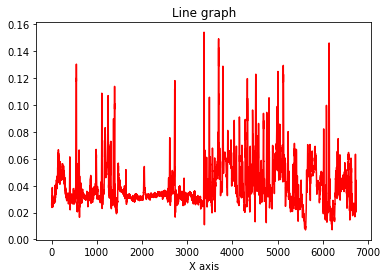

In [80]:
geodesic_dist_np = geodesic_dist(tensor_dataset_true, tensor_dataset_pred).numpy()
# plotting
plt.title("Line graph")
plt.xlabel("X axis")
plt.plot(geodesic_dist_np, color ="red")
plt.show()

In [61]:
geodesic_dist_np = geodesic_dist(tensor_dataset_true, tensor_dataset_pred).numpy()
mae_ang = np.sum(ang_dists) / ang_dists.shape[0]
mae_ang


0.26937224553052824

In [40]:
ang_mae(tensor_dataset_true, tensor_dataset_pred)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul]